## Búsqueda Local Estocástica
### Optimización de parámetros de indicadores técnicos

Este cuaderno muestra como utilizar búsqueda local estocástica para encontrar el mejor conjunto de parámetros del oscilador estocástico para maximizar el rendimiento que habría obtenido sobre un histórico de precios

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import itertools

### Datos 
Trajabajeremos sobre la serie de precios de un activo. Ej. Inditex

In [2]:
import pickle
with open('../data/stock_data.pkl', 'rb') as handle:
    stock_data = pickle.load(handle)

In [21]:
stock_series = stock_data['ITX'].close
stock_series = stock_series.loc['2014':]

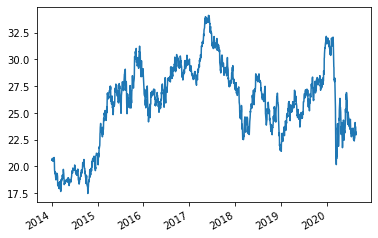

In [22]:
stock_series.plot()

___

**Oscilador estocástico**

In [23]:
def min_max_scale(s):
    """
    Calcula para un vector s su normalización en el rango [0, 1]
    """
    return (s[-1] - np.min(s)) / (np.max(s) - np.min(s))

In [24]:
def stochastic_osc(s, win, lag):
    """
    Calcula el valor del oscilador estocástico
     1. calcula la posición relativa del precio en una ventana temporal
     2. Suaviza la señal anterior haciendo una media móvil, con tamaño inferior al de la ventana
    """
    so_raw = s.rolling(window=win).apply(min_max_scale, raw=True)
    so = so_raw.rolling(window=lag).mean()
    return so  

In [25]:
def stochastic_osc_signal(s, win=14, lag=3, obought=0.8, osold=0.2):
    """
    Calcula el estado de inversión "dentro" (1) o "fuera" (0) siguiendo
    la señal del oscilador estocástico. Esto es:
    - Se compra cuando se cruza de forma ascendente el umbral de sobreventa
    - Se vende cuando se cruza de forma descendente el umbral de sobrecompra
    """
    states = pd.Series(np.zeros(s.shape[0]), index=s.index)
    so = stochastic_osc(s, win, lag)
    if so.iloc[0] > osold:
        states.iloc[:1] = 1
        curr = 1
    else:
        curr = 0
    
    for i in range(s.shape[0] - 2):
        if so.iloc[i] < osold and so.iloc[i+1] >= osold:
            curr = 1
        elif so.iloc[i] > obought and so.iloc[i+1] <= obought: 
            curr = 0
        states.iloc[i+2] = curr
    
    return states

def state_returns(price, states):
    """ Calcula para una serie y unos estados de 
    estar dentro fuera, cual es el retorno total
    correspondiente.
    Se debe tener el mismo Index de pandas 
    """
    log_ret = np.log(price).diff()
    log_ret.iloc[0] = 0
    
    in_rets = log_ret * states
    total_log_ret = in_rets.sum()
    simple_ret = np.exp(total_log_ret) - 1
    return simple_ret
    

In [26]:
def backtest_so_returns(vseries, win=14, lag=3, obought=0.8, osold=0.2):
    """
    A partir de una serie de precios, calcula el rendimiento del oscilador estocástico 
    con los parámetros correspondientes
    """
    f_states = stochastic_osc_signal(
        vseries, 
        win=win, 
        lag=lag,
        obought=obought,
        osold=osold)
    so_return = state_returns(vseries, f_states)
    return so_return

In [27]:
backtest_so_returns(stock_series)

0.23667751046107655

### Búsqueda Aleatoria
Primero realizaremos una búsqueda aleatoria en un espacio de parámetros para ver las capacidades
de una exploración **sin un algoritmo** de búsqueda especializado.

In [28]:
obought_space = np.linspace(0.51,0.98,48)
obought_space

array([0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61,
       0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72,
       0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83,
       0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94,
       0.95, 0.96, 0.97, 0.98])

In [29]:
osold_space = np.linspace(0.02,0.49,48)
osold_space

array([0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11, 0.12,
       0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22, 0.23,
       0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33, 0.34,
       0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44, 0.45,
       0.46, 0.47, 0.48, 0.49])

In [30]:
win_space = np.arange(10,120)
win_space

array([ 10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,
        23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,
        36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,
        49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
        62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,
        75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,
        88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100,
       101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
       114, 115, 116, 117, 118, 119])

In [31]:
lag_space = np.arange(1,50)
lag_space

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [32]:
# numero de estados posibles en el espacio de parametros que hemos definido
win_space.shape[0]*lag_space.shape[0]*obought_space.shape[0]*osold_space.shape[0]

12418560

In [33]:
# A partir del espacio de parámetros que hemos definido anteriormente
# podemos generar set de parametros aleatorios, solo con la condición
# que el lag sea menor que la ventana
def rand_state():
    win = np.random.choice(win_space)
    avail_lag = lag_space[lag_space < win]
    
    state =  {
        'win': win,
        'lag': np.random.choice(avail_lag), 
        'obought':np.random.choice(obought_space), 
        'osold':np.random.choice(osold_space)
    }
    return state

In [34]:
rstate = rand_state()
rstate 

{'win': 18, 'lag': 10, 'obought': 0.91, 'osold': 0.48000000000000004}

In [35]:
# rendimiento sobre los parámetros aleatorios
backtest_so_returns(stock_series, **rstate)

0.06933061773294869

Generaremos estados n aleatorios y guardaremos el máximo obtenido hasta el momento

In [36]:
n = 200
best_return = -1
for i in range(n):
    i_state = rand_state()
    i_return = backtest_so_returns(stock_series, **i_state)
    if i_return > best_return:
        best_return = i_return
        print (f'{i}: return:{best_return} -->{i_state}')
    

0: return:0.0 -->{'win': 108, 'lag': 37, 'obought': 0.8300000000000001, 'osold': 0.05}
1: return:0.22994801364195872 -->{'win': 69, 'lag': 25, 'obought': 0.9, 'osold': 0.36000000000000004}
2: return:0.4633741073042912 -->{'win': 43, 'lag': 38, 'obought': 0.91, 'osold': 0.44}
27: return:1.0182717336630303 -->{'win': 114, 'lag': 24, 'obought': 0.96, 'osold': 0.48000000000000004}
175: return:1.4190716865446245 -->{'win': 47, 'lag': 31, 'obought': 0.92, 'osold': 0.30000000000000004}


___

### Búsqueda Local Estocástica
En este apartado utilizaremos técnicas de SLS para mejorar la exploración sobre 
el conjunto de parámetros

Primero tenemos que definir una función que calcula la "vencidad" de un nodo, esto es,
el conjunto de estados a los que podríamos movernos en un paso de la búsqueda

In [37]:
def sucesores(params):
    min_win, max_win=10, 120
    min_lag, max_lag=1, 50
    min_ob, max_ob=0.51,0.98
    min_os, max_os=0.02,0.49 
    
     # win=14, lag=3, obought=0.8, osold=0.2
    succ = []
    s = params.copy()
    if s['win'] < max_win:
        s['win'] += 1
        succ.append(s)
        
    s = params.copy()
    if s['win'] > min_win:
        s['win'] -= 1
        succ.append(s)
        
    s = params.copy()
    if s['lag'] < max_lag and s['lag']+1 < s['win']:
        s['lag'] += 1
        succ.append(s)
        
    s = params.copy()
    if s['lag'] < max_lag and s['lag'] > 0:
        s['lag'] -= 1
        succ.append(s)
    
    s = params.copy()
    if s['obought'] < max_ob:
        s['obought'] += 0.02
        succ.append(s)
    
    s = params.copy()
    if s['obought'] > min_ob:
        s['obought'] -= 0.02
        succ.append(s)
    
    s = params.copy()
    if s['osold'] < max_os:
        s['osold'] += 0.02
        succ.append(s)
    
    s = params.copy()
    if s['osold'] > min_os:
        s['osold'] -= 0.02
        succ.append(s)
        
    return succ

In [38]:
root = {
    'win':15,
    'lag':3, 
    'obought':0.8, 
    'osold':0.2
}

In [39]:
sucesores(root)

[{'win': 16, 'lag': 3, 'obought': 0.8, 'osold': 0.2},
 {'win': 14, 'lag': 3, 'obought': 0.8, 'osold': 0.2},
 {'win': 15, 'lag': 4, 'obought': 0.8, 'osold': 0.2},
 {'win': 15, 'lag': 2, 'obought': 0.8, 'osold': 0.2},
 {'win': 15, 'lag': 3, 'obought': 0.8200000000000001, 'osold': 0.2},
 {'win': 15, 'lag': 3, 'obought': 0.78, 'osold': 0.2},
 {'win': 15, 'lag': 3, 'obought': 0.8, 'osold': 0.22},
 {'win': 15, 'lag': 3, 'obought': 0.8, 'osold': 0.18000000000000002}]

In [40]:
def iterative_improvement_so(vseries, params, niter=30):
    state = params
    hbase = backtest_so_returns(vseries, **state)
    i = 0
    while i < niter:
        i = i +1
        succ = sucesores(state)
        h_vals = [backtest_so_returns(vseries, **c_i) for c_i in succ]
        best_idx = h_vals.index(max(h_vals))
        best_succ = succ[best_idx]
        best_h = h_vals[best_idx]
        #print(f"best_h {round(best_h,3)}")
        if best_h > hbase:
            state = best_succ
            hbase = best_h
            print (f'{i}: return:{best_h} -->{best_succ}')
        else:
            #print("no better successor")
            break
            
    return state, hbase


In [45]:
init_state = rand_state()
iterative_improvement_so(stock_series, init_state, niter=30)

1: return:-0.13918995342815277 -->{'win': 62, 'lag': 38, 'obought': 0.53, 'osold': 0.36000000000000004}
2: return:-0.03606172305594357 -->{'win': 63, 'lag': 38, 'obought': 0.53, 'osold': 0.36000000000000004}


({'win': 63, 'lag': 38, 'obought': 0.53, 'osold': 0.36000000000000004},
 -0.03606172305594357)

In [46]:
def sortedrestart_iimprovements_so(vseries, restarts=20):
    init_states = [rand_state() for i in range(restarts)]  
    h_vals = [backtest_so_returns(vseries, **c_i) for c_i in init_states]
    h_sorted_idx = sorted(range(len(h_vals)), 
                          key=lambda k: h_vals[k],
                          reverse=True)
    
    global_best = -1 

    for i, idx_sorted in enumerate(h_sorted_idx):
        iparams = init_states[idx_sorted]
        print(f"New restart {i}...")
        best_restart, h_restart = iterative_improvement_so(stock_series, iparams, 10)
        
        if h_restart > global_best:
            global_best = h_restart
            global_state = best_restart
            print (f'{i}: Global improvement, return:{h_restart} -->{best_restart}')
        
    return global_state, global_best


In [47]:
res_res = sortedrestart_iimprovements_so(stock_series, restarts=25)    


New restart 0...
1: return:0.7201573666151055 -->{'win': 109, 'lag': 28, 'obought': 0.9199999999999999, 'osold': 0.39}
2: return:0.7593736773820603 -->{'win': 109, 'lag': 28, 'obought': 0.9199999999999999, 'osold': 0.41000000000000003}
0: Global improvement, return:0.7593736773820603 -->{'win': 109, 'lag': 28, 'obought': 0.9199999999999999, 'osold': 0.41000000000000003}
New restart 1...
1: return:0.7159278935722184 -->{'win': 33, 'lag': 12, 'obought': 0.99, 'osold': 0.39}
2: return:0.7847002434947143 -->{'win': 32, 'lag': 12, 'obought': 0.99, 'osold': 0.39}
1: Global improvement, return:0.7847002434947143 -->{'win': 32, 'lag': 12, 'obought': 0.99, 'osold': 0.39}
New restart 2...
1: return:0.5315217653720266 -->{'win': 112, 'lag': 13, 'obought': 0.69, 'osold': 0.39}
2: return:0.650627860382432 -->{'win': 112, 'lag': 13, 'obought': 0.69, 'osold': 0.37}
3: return:0.6553347542510088 -->{'win': 112, 'lag': 13, 'obought': 0.69, 'osold': 0.35}
4: return:0.6795307552629226 -->{'win': 112, 'lag

In [ ]:
res_res